# 1. Introduction
## 1.1. Problem Statement

### In this assignment, we need to design an **aviation environmental design tool(AEDT)** using **GMM with EM algorithm**.
---
* Develop a GMM with EM code from **scratch**.
* You will receive points only if
your code **runs correctly without errors** and **finishes within five minutes**.
* Implement the **GMM with EM code** you developed to cluster the provided dataset.
* Visualize scatter plots for different clusters with **K=2, 3, 4, and 5**.
* How would you persuade people that your code has executed **enough iterations**
* Which value of K do you consider to be the most suitable? Propose a way for assessing and determining the **optimal K**.

# 2. Imports
## 2.1. Import Libraries

In [395]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import time

## 2.2. Load Dataset

In [396]:
# Load the dataset
dataset = pd.read_csv("/content/drive/MyDrive/9th semester/Machine Learning/FAA_AEDT_data.csv")
# Make dataframe into array
data = np.column_stack([dataset['x1'], dataset['x2']])
dataset.head()

,x1,x2
0,-3.970,-4.650
1,-4.960,-1.250
2,-0.919,-7.330
3,-4.160,-9.630
4,0.236,0.732


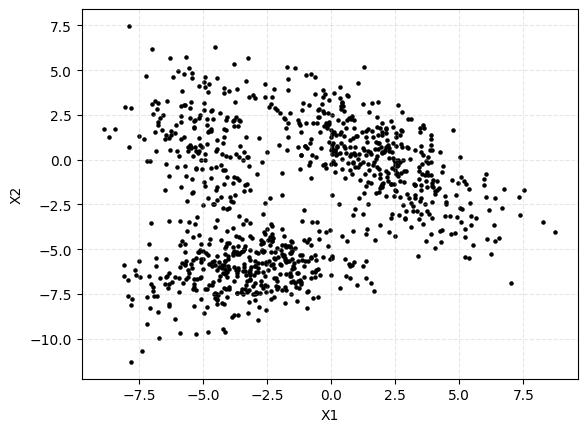

In [397]:
# Visualize the data
plt.scatter(dataset['x1'], dataset['x2'], c = 'k', s = 5)
plt.xlabel('X1', fontsize = 10)
plt.ylabel('X2', fontsize = 10)
plt.grid(True, alpha = 0.3,linestyle = '--')
plt.show()

## 2.3. Seeding

In [398]:
# Fix the seed number for reproducibility
np.random.seed(2023)

# 3. Implementing GMM-EM Algorithm
* The EM algorithm can be considered as a tool for **estimating the parameters of a GMM**.
* The EM algorithm works by **first initializing the parameters of a GMM, then iteratively improving these estimates.**

## 3.1 Start with unlabeled data points
* Assume that we have specified K to place **K center points randomly on the datasets**

In [399]:
# Number of clusters
K2 = 2
K3 = 3
K4 = 4
K5 = 5

## 3.2. Initialization.
* Randomly place K Gaussian distributions
  * **Initialize the parameters of a GMM**
  * We have to initialize **mean($μ$)** and **covariance($β$)** according to PDF formula below.
  <br>
  <br>
  <p text-align = center>

  ${PDF = \frac{1}{2\pi^{D/2}|{β}|^{1/2}}exp[-\frac{1}{2}(x-μ)^Tβ^{-1}(x-μ)] }$
  
  </p>

In [400]:
# Make a function to initialize parameters
def initialize_parameters(data, K):
    # N is the number of datapoints in dataset.
    N, D = data.shape
    # Initialize the mean
    mu = data[np.random.choice(N, K, replace=False)]
    # Initialize the covarience, covariance for each distribution is identity matrix in which diagonal axis means the covariance
    cov = np.array([np.identity(D) for _ in range(K)])
    # Initialize the pi, mixing coefficient
    pi = np.ones(K) / K
    return mu, cov, pi

## 3.3. E step (Expectation)
* Assign the data points to either Gaussian 1, Gaussian 2,..., or Gaussian K (without hard assignment)
   - Given the randomly initialized parameters, visit each point and ask which Gaussian distribution does this data point come from?
* Evaluate the **responsibilites (r)** to assign the data points to a specific clustering group

  * ${π_i}$: initial mixing coefficient
  <p align = center>
  ${π_i = 1/K}$
  </p>
  <br>
  * ${p(x_i|μ,β)}$: Posterior Possibility
  <p align = center>
  ${{p(x_i|μ,β) = \frac{1}{(2\pi^{D/2}|{β}|)^{1/2}}exp[-\frac{1}{2}(x-μ)^Tβ^{-1}(x-μ)]}}$
  </p>
  <br>
  * ${r}$: responsibility, the corresponding posterior probabilities for a given value of x.  
  (Note that it may be necessary to normalize the responsibility array for computational stability.)
  <p align = center>
  ${r_{k}(x) = \frac{π_k * p(x_j|μ_k,β_k)}{∑^K_{i=1}π_i * p(x_j|μ_i,β_i)}}$
  </p>

In [401]:
# E-step
def E_step(data, mu, cov, pi):
    N, _ = data.shape
    K = len(mu)
    # Construct an array for responsibility
    responsibility = np.zeros((N, K))

    # Evaluate the responsibility with given parameters of each distribution 1, 2, ..., K.
    for k in range(K):
        responsibility[:, k] = pi[k] * multivariate_normal.pdf(data, mean=mu[k], cov=cov[k])

    # Normalize the responsibility array for computational stability.
    responsibility /= responsibility.sum(axis=1, keepdims=True)

    return responsibility

## 3.4. M step (Maximization)
* Re-estimate **the parameters of a GMM** to fit the assigned data points
* Each cluster group will get $μ_{new}, β_{new}, π_{new}$
  * $N = number\,of\,data\,point$
    
  * ${π_j = \frac{1}{N}∑^N_{n=1}r_j(x_n)}$
    
  * ${μ_j = \frac{∑^N_{n=1}r_j(x_n)*x_n}{∑^N_{n=1}r_j(x_n)}}$
    
  * ${β_j = \frac{∑^N_{n=1}r_j(x_n)*(x_n-μ_j)^T(X_n-μ_j)}{∑^N_{n=1}r_j(x_n)}}$

In [402]:
# M-step
def M_step(data, responsibility):
    N, D = data.shape
    K = responsibility.shape[1]

    Nk = responsibility.sum(axis=0)

    # Update mu
    # We can speed up the calculation of
    mu = np.dot(responsibility.T, data) / Nk[:, np.newaxis]
    cov = np.zeros((K, D, D))

    for k in range(K):
        diff = data - mu[k]
        cov[k] = np.dot(responsibility[:, k] * diff.T, diff) / Nk[k]

    # Update pi
    pi = Nk / N

    return mu, cov, pi


## 3.5. Keep iterating both E-step and M-step until convergence criterion satisfied.
* Possible option
  * Comparing the change in **log-likelihood (${L}$)** from the previous iteration or specifying the maximum number of iterations.
  
  <p align = center>
  ${L = ∑^N_{i=1}log(∑^K_{j=1}π_jp(x_j|μ_i,β_i))}$
  </p>
  
    * $N$ = numbe of data point
    * $K$ = number of Gaussian components
    * ${\pi_j}$ = mixing coefficient for component j
    * ${p}$ = responsibility of data point x_i with respect to component j

In [403]:
# Calculate log likelihood
def compute_loss(data, mu, cov, pi, responsibility):
    N, _ = data.shape
    K = len(mu)
    log_likelihood = np.sum(np.log(np.sum([pi[k] * multivariate_normal.pdf(data, mean=mu[k], cov=cov[k])
                                           for k in range(K)], axis=0)))
    return -log_likelihood / N

In [404]:
# Combine all the functions above to make EM Algorithm function
def GMM_EM(data, K, num_iterations=100):
    mu, cov, pi = initialize_parameters(data, K)
    loss_history = []

    for i in range(num_iterations):
        responsibility = E_step(data, mu, cov, pi)
        mu, cov, pi = M_step(data, responsibility)
        loss = compute_loss(data, mu, cov, pi, responsibility)
        loss_history.append(loss)

    return mu, cov, pi, loss_history

In [405]:
# Make a function to measure execution time
def measure_execution_time(func, *args):
    start_time = time.time()
    result = func(*args)
    end_time = time.time()
    execution_time = end_time - start_time
    return result, execution_time

In [406]:
# Visualize the results
def plot_gmm_clusters(data, mu, cov, title, responsibility):
    plt.figure(figsize=(8, 6))

    # Assign colors based on cluster assignment
    colors = np.argmax(responsibility, axis=1)

    # Plot data points with assigned colors
    plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='viridis', alpha=0.7)


    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

# Plot the data and estimated clusters
def plot_gmm(data, mu, cov, K, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
    for k in range(K):
        plot_ellipse(mu[k], cov[k], alpha=0.5, color='r')
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

def plot_loss(loss_history, K):
  convergence_threshold = 1e-4 # How can we say if the loss is not changing anymore?
  converged_time = 10 # How many times does the loss difference should be almost 0 to say it is converged
  converged = None

  for i in range(1, len(loss_history)):
    if abs(loss_history[i] - loss_history[i-1]) < convergence_threshold:
      if converged is None:
        converged = i -1 # previous iteration num where loss converged
      elif i - converged >= converged_time:
        break # If loss was not changed for the specified window, it is converged

  plt.figure(figsize=(8, 6))
  plt.plot(loss_history)

  if converged is not None:
    plt.axvline(x=converged, color='red', linestyle='--', label=f'Converged at Iteration {converged}')
    plt.legend()


  plt.title(f'Loss vs. Iterations (K ={K})')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.show()

def plot_ellipse(mu, cov, alpha, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    width, height = 2 * np.sqrt(5.991 * eigenvalues)
    ellipse = plt.matplotlib.patches.Ellipse(mu, width, height, angle=np.degrees(angle), alpha=alpha, color=color)
    plt.gca().add_patch(ellipse)

# 4. Run the GMM-EM algorithm
## 4.1. When K = 2
### 4.1.1 Fit the GMM-EM

In [407]:
# Fit the GMM
result, execution_time = measure_execution_time(GMM_EM, data, K2)
mu_est, cov_est, pi_est, loss_history = result
# Calculate cluster assignment probabilities using E-step
responsibility = E_step(data, mu_est, cov_est, pi_est)

### 4.1.2 Visualization of result

Execution time: 0.23 seconds


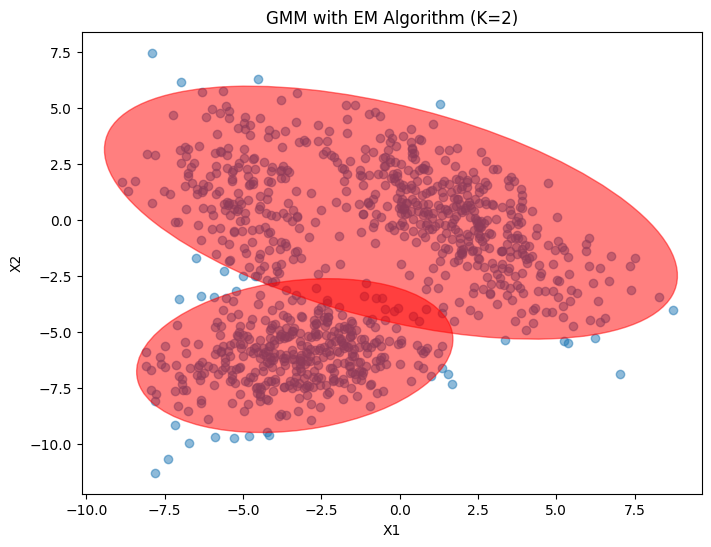

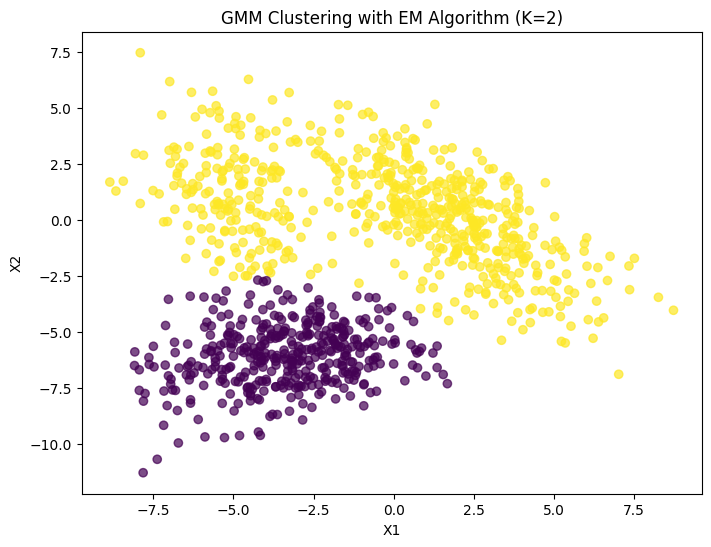

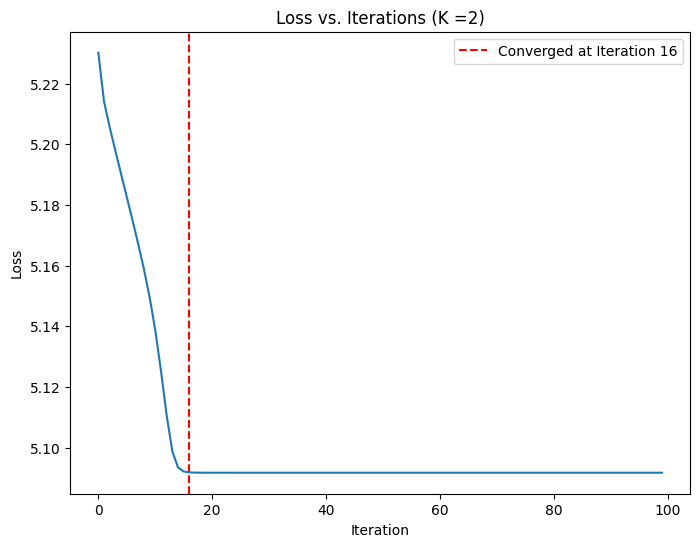

In [408]:
# When K is 2
print(f"Execution time: {execution_time:.2f} seconds")
plot_gmm(data, mu_est, cov_est, K2, "GMM with EM Algorithm (K=2)")
# Plot the data points with colors by cluster assignment
plot_gmm_clusters(data, mu_est, cov_est, "GMM Clustering with EM Algorithm (K=2)", responsibility)
plot_loss(loss_history, K2)

## 4.2 When K = 3
### 4.2.1 Fit the GMM-EM


In [409]:
# Fit the GMM
result, execution_time = measure_execution_time(GMM_EM, data, K3)
mu_est, cov_est, pi_est, loss_history = result
# Calculate cluster assignment probabilities using E-step
responsibility = E_step(data, mu_est, cov_est, pi_est)

### 4.2.2. Visualization of result

Execution time: 0.23 seconds


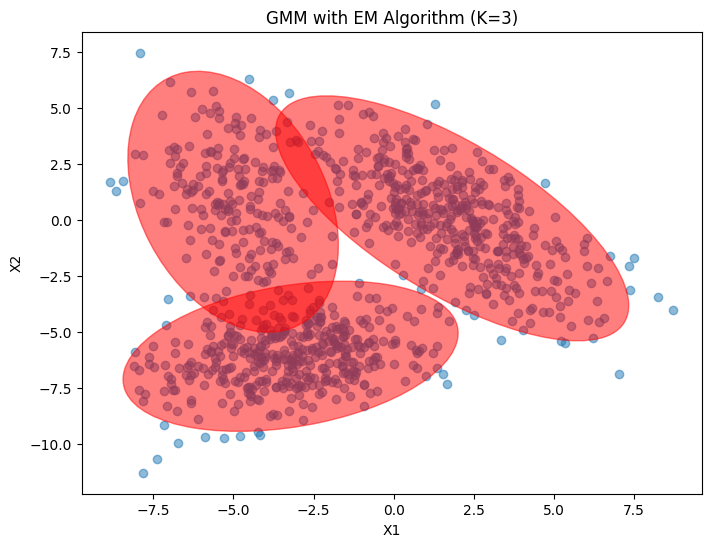

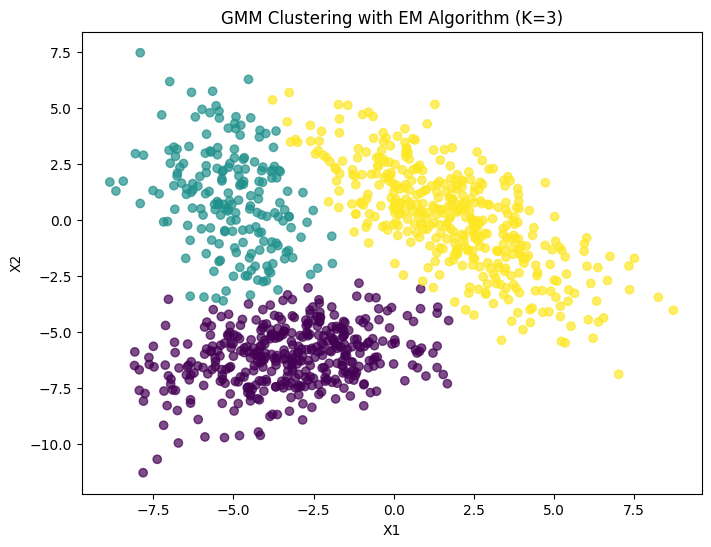

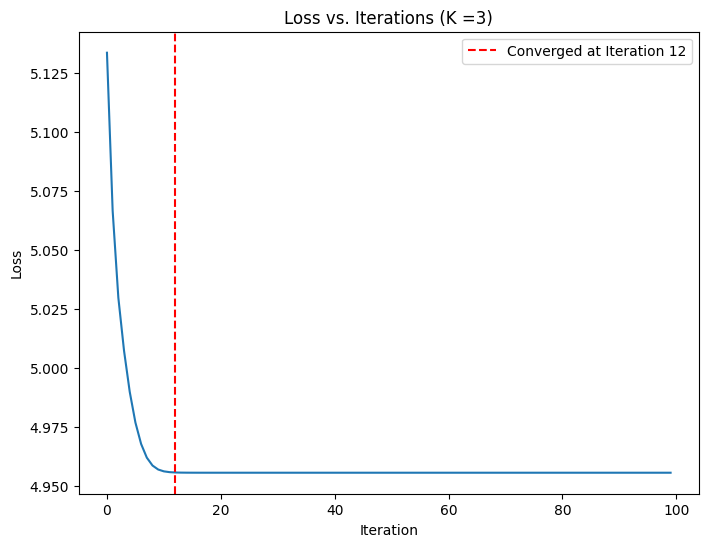

In [410]:
# When K is 3
print(f"Execution time: {execution_time:.2f} seconds")
plot_gmm(data, mu_est, cov_est, K3, "GMM with EM Algorithm (K=3)")
# Plot the data points with colors by cluster assignment
plot_gmm_clusters(data, mu_est, cov_est, "GMM Clustering with EM Algorithm (K=3)", responsibility)
plot_loss(loss_history, K3)

## 4.3. When K = 4
### 4.3.1. Fit the GMM-EM

In [411]:
# Fit the GMM
result, execution_time = measure_execution_time(GMM_EM, data, K4)
mu_est, cov_est, pi_est, loss_history = result
# Calculate cluster assignment probabilities using E-step
responsibility = E_step(data, mu_est, cov_est, pi_est)

### 4.3.2. Visualize the result

Execution time: 0.25 seconds


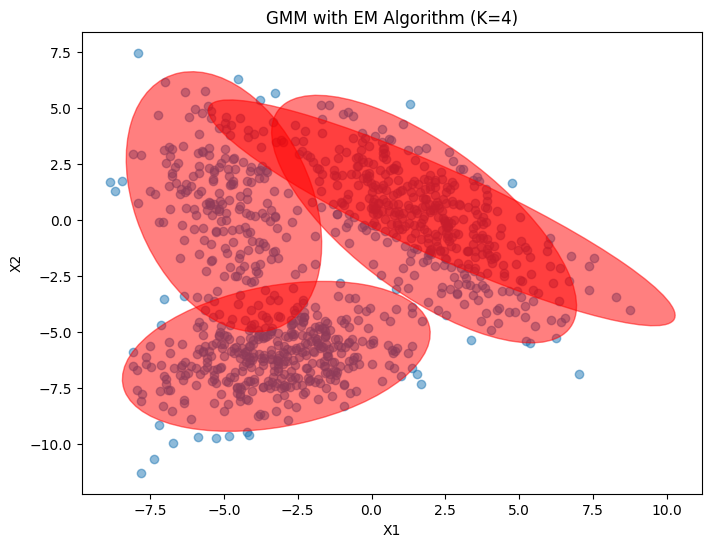

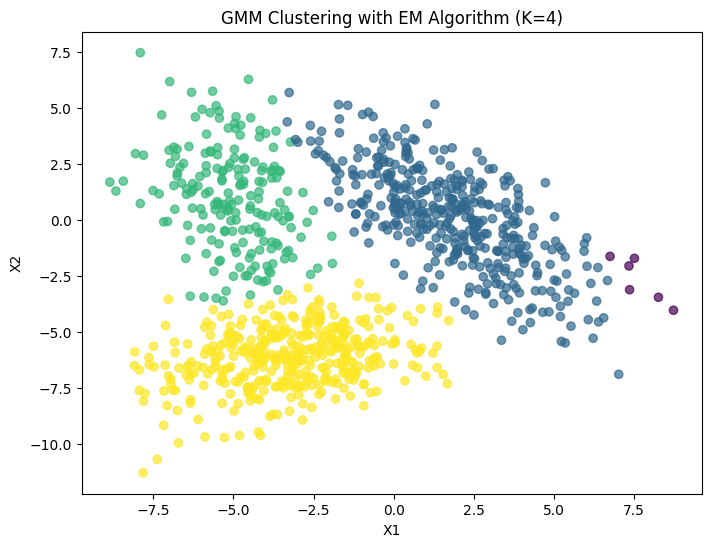

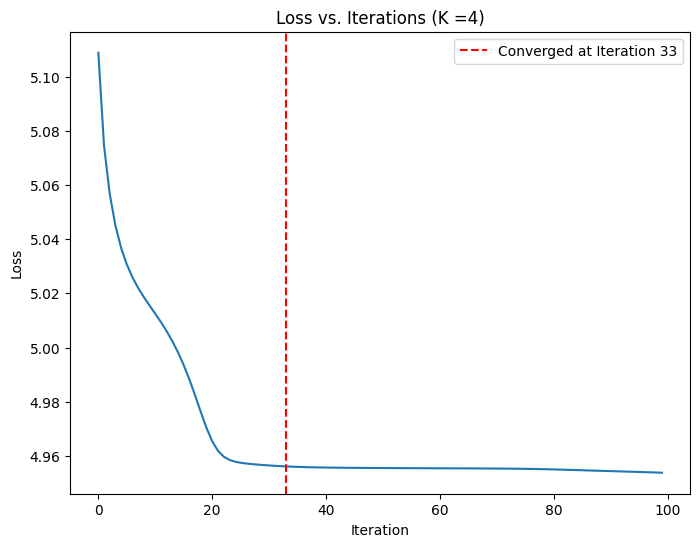

In [412]:
# When K is 4
print(f"Execution time: {execution_time:.2f} seconds")
plot_gmm(data, mu_est, cov_est, K4, "GMM with EM Algorithm (K=4)")
# Plot the data points with colors by cluster assignment
plot_gmm_clusters(data, mu_est, cov_est, "GMM Clustering with EM Algorithm (K=4)", responsibility)
plot_loss(loss_history, K4)

## 4.4 When K = 5
### 4.4.1. Fit the GMM-EM

In [413]:
# Fit the GMM
result, execution_time = measure_execution_time(GMM_EM, data, K5)
mu_est, cov_est, pi_est, loss_history = result
# Calculate cluster assignment probabilities using E-step
responsibility = E_step(data, mu_est, cov_est, pi_est)

### 4.3.2. Visualize the result

Execution time: 0.28 seconds


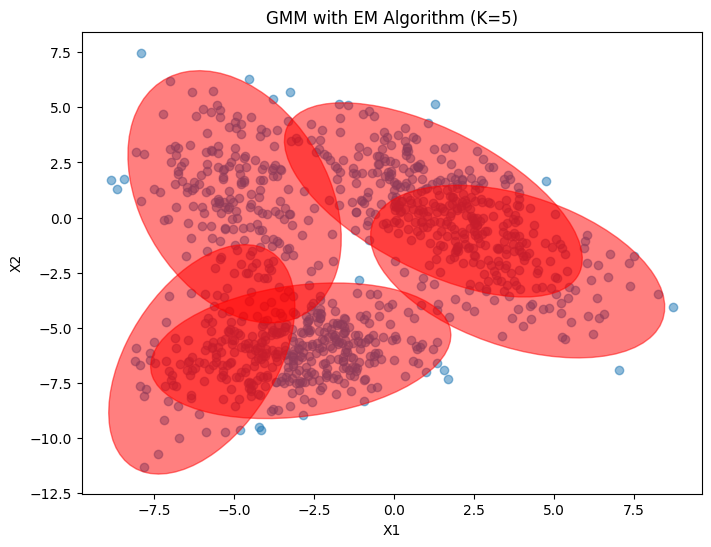

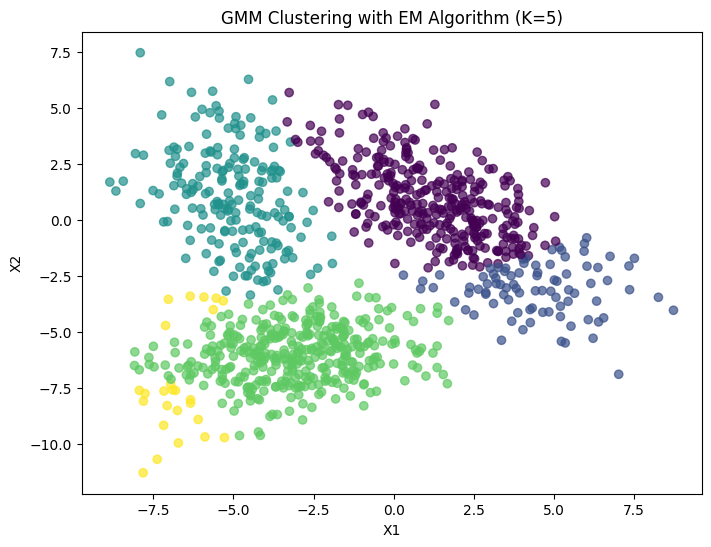

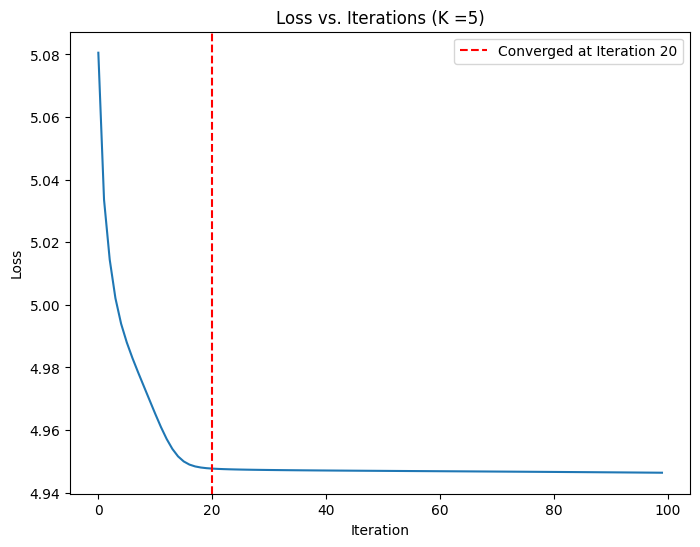

In [414]:
# When K is 5
print(f"Execution time: {execution_time:.2f} seconds")
plot_gmm(data, mu_est, cov_est, K5, "GMM with EM Algorithm (K=5)")
# Plot the data points with colors by cluster assignment
plot_gmm_clusters(data, mu_est, cov_est, "GMM Clustering with EM Algorithm (K=5)", responsibility)
plot_loss(loss_history, K5)

### 4.3.3. Increase the iteration number

In [415]:
# Fit the GMM
result, execution_time = measure_execution_time(GMM_EM, data, K5, 500)
mu_est, cov_est, pi_est, loss_history = result
# Calculate cluster assignment probabilities using E-step
responsibility = E_step(data, mu_est, cov_est, pi_est)

Execution time: 1.46 seconds


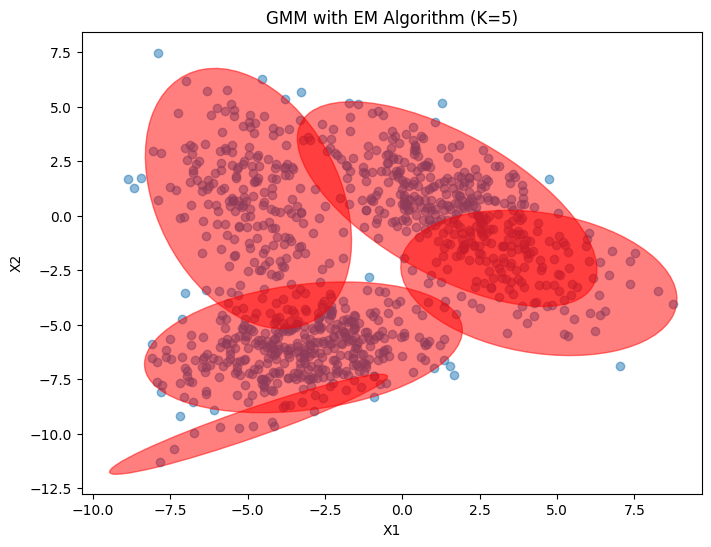

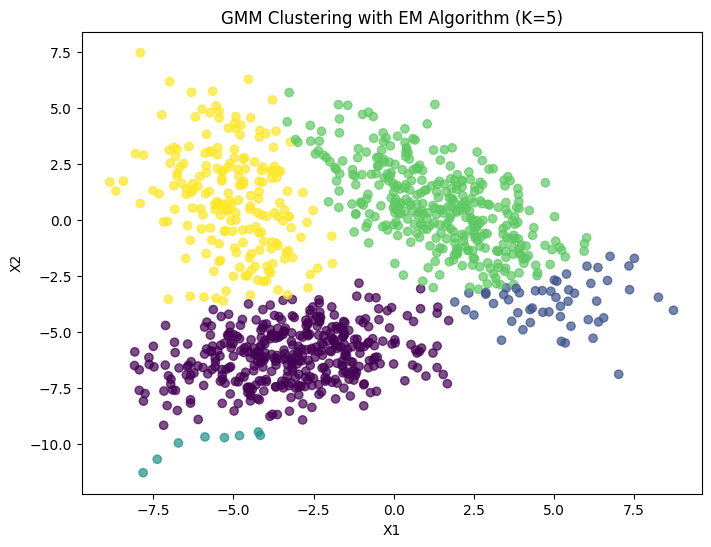

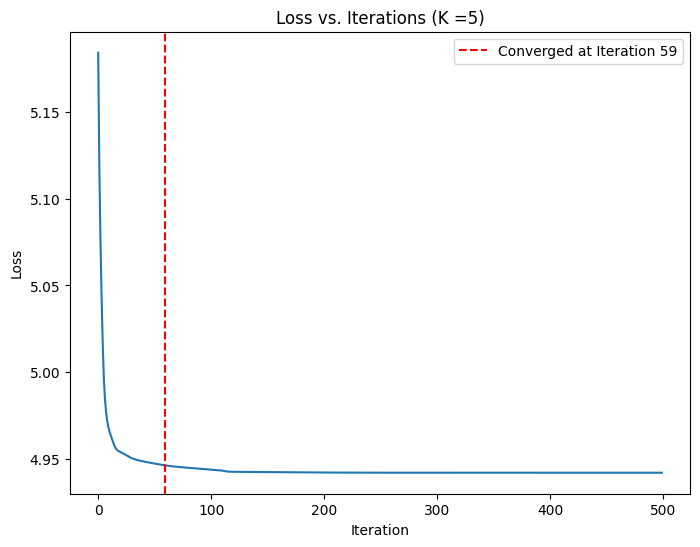

In [416]:
# Increase the iteration number when K = 5
print(f"Execution time: {execution_time:.2f} seconds")
plot_gmm(data, mu_est, cov_est, K5, "GMM with EM Algorithm (K=5)")
# Plot the data points with colors by cluster assignment
plot_gmm_clusters(data, mu_est, cov_est, "GMM Clustering with EM Algorithm (K=5)", responsibility)
plot_loss(loss_history, K5)

# 5. Determine the optimal K
* How can we determine the optimal K?
* I chose **Elbow method** to determine the best K


## 5.1. Elbow method
1. Fit GMM models with various values of K
2. Calculate the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC) for each model. In this code, we will employ BIC, and the formula for BIC is below:
<p align = center>
${BIC = log(n)k - 2log(L)}$
</p>

  * **k**= number of independent variables to build model
  * **L**= maximum likelihood estimate of model
  * **n** = sample size (#observations)
  * **log-base** = e(natural log)
3. Plot the BIC or AIC values against the number of clusters (K).
4. Look for an 'elbow' point in the plot, where the decrease in BIC or AIC starts to slow down. The elbow point suggests a reasonable number of clusters.

In [417]:
# Make a function to calculate BIC
def compute_bic(data, mu, cov, pi, responsibility):
  N, D = data.shape
  K = len(mu)
  log_likelihood = np.sum(np.log(np.sum([pi[k] * multivariate_normal.pdf(data, mean=mu[k], cov=cov[k]) for k in range(K)], axis=0)))
  num_parameters = K * (D + D*(D + 1) // 2) + (K - 1)  # Parameters for means, covariances, and mixing coefficients
  bic = num_parameters * np.log(N) - 2 * log_likelihood
  return bic

def elbow_method(data, max_K):
  bics = []

  for k in range(1, max_K + 1):
    mu_est, cov_est, pi_est, loss_history = GMM_EM(data, k)
    responsibility = E_step(data, mu_est, cov_est, pi_est)
    bic = compute_bic(data, mu_est, cov_est, pi_est, responsibility)
    bics.append(bic)

  # Plot BIC values against K
  plt.plot(range(1, max_K + 1), bics, marker='o')
  plt.xlabel('Number of Clusters (K)')
  plt.ylabel('BIC')
  plt.title('Elbow Method: BIC vs. K')
  plt.vlines(bics.index(min(bics))+1, min(bics)-100, max(bics), colors = 'r', linestyle = '--')
  plt.show()

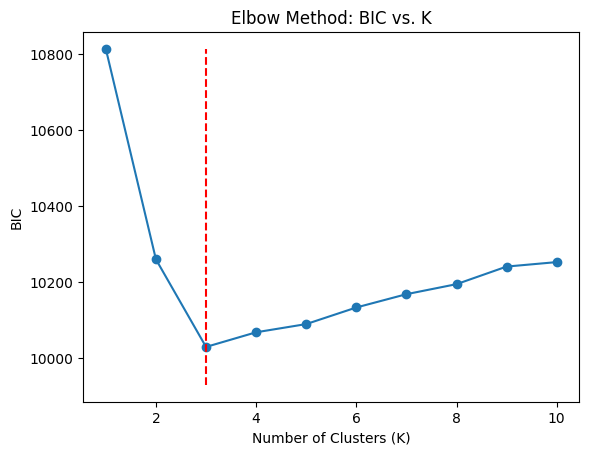

In [418]:
# Define max number of K:
max_K = 10

# Visulize the elbow method
elbow_method(data, max_K)

[Reference]
1. Towardsdatascience | Gaussian mixture models implemented from scratch
https://towardsdatascience.com/gaussian-mixture-models-implemented-from-scratch-1857e40ea566
2. Github | GMM.py by ScienceKot https://github.com/ScienceKot/mysklearn/blob/master/Gaussian%20Mixture%20Models/GMM.py
3. Github | EM-GMM algorithm with built in visualization tools by Napam https://github.com/Napam/emgmm/blob/master/emgmm.py
4. Wikidocs | Matplotlib Tutorial, https://wikidocs.net/book/5011  
5. Towardsdatascience | Gaussian Misture Model clustering: how to select the number of components (clusters), https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
6. Statology | How to Use the Elbow Method in Python to Find Optimal Clusters, https://www.statology.org/elbow-method-in-python/
7. Medium | Probabilistic Model Selection with AIC/BIC in Python, https://medium.com/analytics-vidhya/probabilistic-model-selection-with-aic-bic-in-python-f8471d6add32
8. ChatGPT, https://chat.openai.com/c/6dc18ca9-0f65-4f84-b522-bf4c43b6b5b9
9. Youtube | ‘Vectorization’ by Andrew Ng https://youtu.be/qsIrQi0fzbY?si=0d-_asUtd1QY27y3
10. Stackflow | Gradient descent convergence how to decide convergence https://stackoverflow.com/questions/17289082/gradient-descent-convergence-how-to-decide-convergence